# Image Blending

Рассмотрим задачу image blending. Суть задачи заключается в том чтобы совместить два изображения в одно так чтобы результат был относительно реалистичным

По сути задачу можно рассматривать в 2 этапа:

1) Необходимо чтобы граница вставки объекта не была четкой(как правило) и не просалась в глаза

2) Нужно изменить внешний вид объекта чтобы он органично вписывался в целевое(в которое вставляется объект) изображение

<img src="images/Deep_Painterly_Harmonization.png"  width="700px" title="aaa">

In [5]:
import cv2
import numpy as np
import sys
sys.path.append('./')  # добавляем небольшой файл с утилитой для вывода изображений

from show import show_image, subplot_images, draw_points

## Simple Blending

Самый простой способ совместить изобаржения, это вставить одно в другое без каких либо изменений

In [7]:
# Пути документа, подписи и маски подписи
image_path = 'source_images/document_image.png'
signature_image_path = 'source_images/signature_image.png'
mask_path = 'source_images/signature_mask.png'

image = cv2.imread(image_path)
signature_image = cv2.imread(signature_image_path)
s_h, s_w = signature_image.shape[:2]
point = (1500, 1000)  # точка куда вставляем подпись 

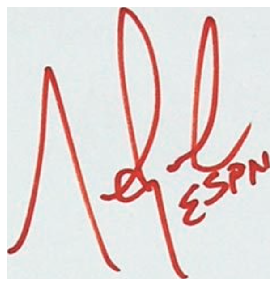

In [8]:
show_image(signature_image, (5, 5))

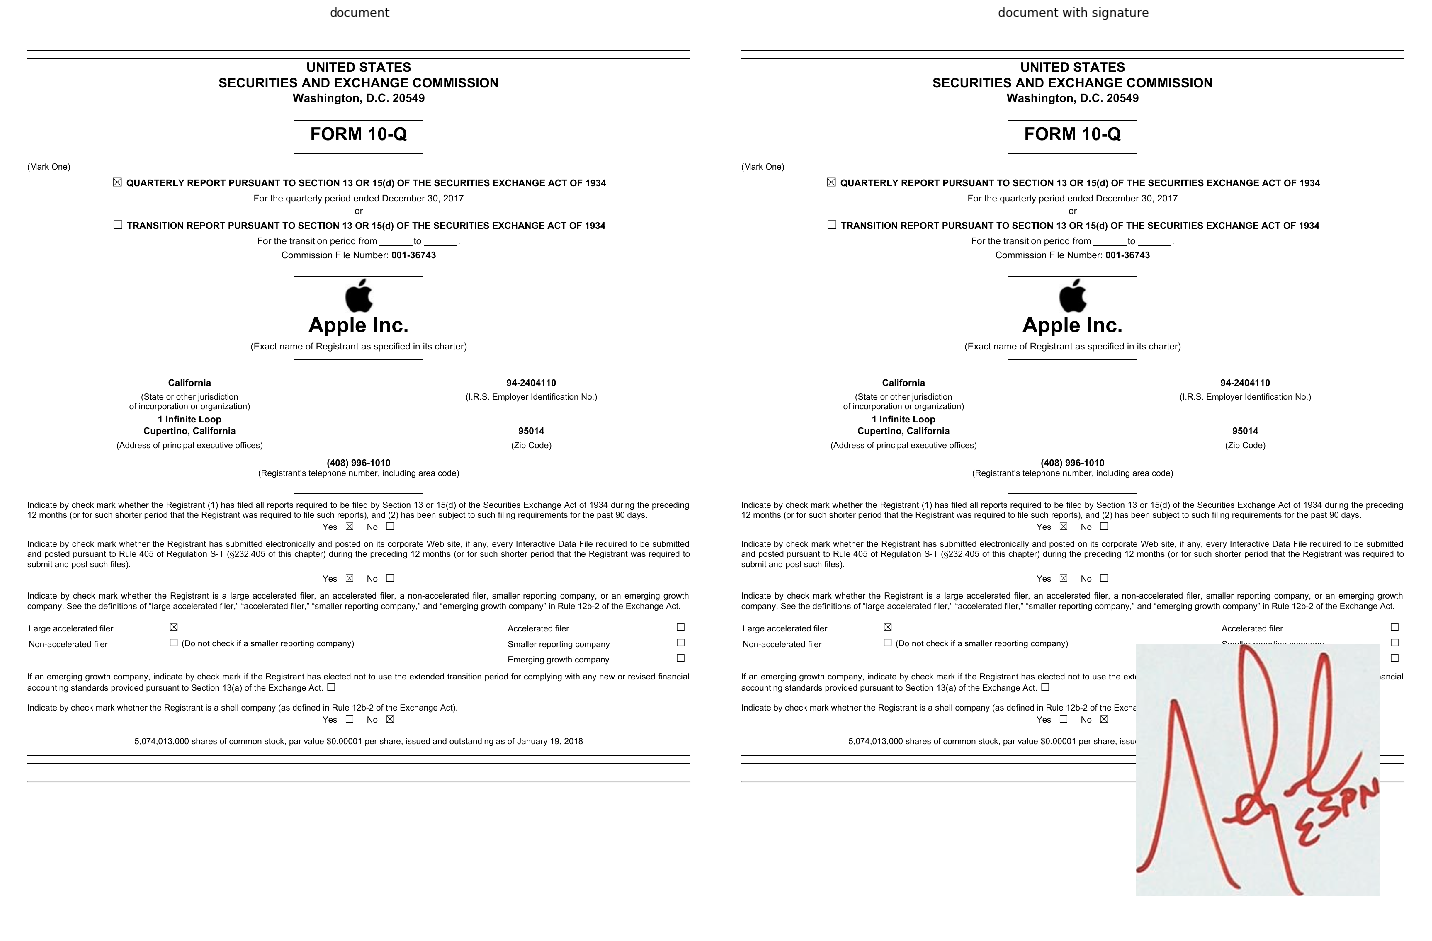

In [9]:
image_with_signature = image.copy()
image_with_signature[point[0]: point[0]+ s_h, point[1]:point[1] + s_w] = signature_image
subplot_images([image, image_with_signature], 1, 2, titles=['document', 'document with signature'])

## Masked(Alpha) Blending

Мы хотим перенести только подпись, а задний фон на котором она находиться переноссить не хочется. В этом случае, можно создать бинарную маску(для этого можно например бинаризовать подпись) и вставлять подпись только там где маска равна 1, а где 0 оставлять исходный документ

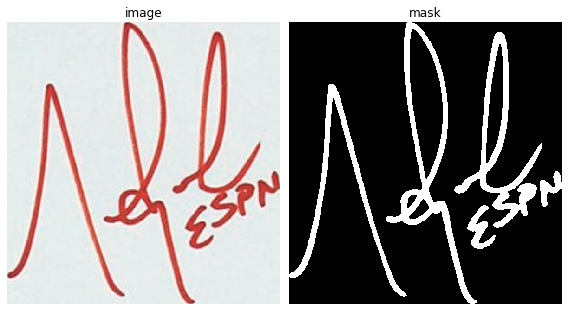

In [10]:
signature_mask = cv2.imread(mask_path)
subplot_images([signature_image, signature_mask * 255], 1, 2, figsize=(8, 8), titles=['image', 'mask'])

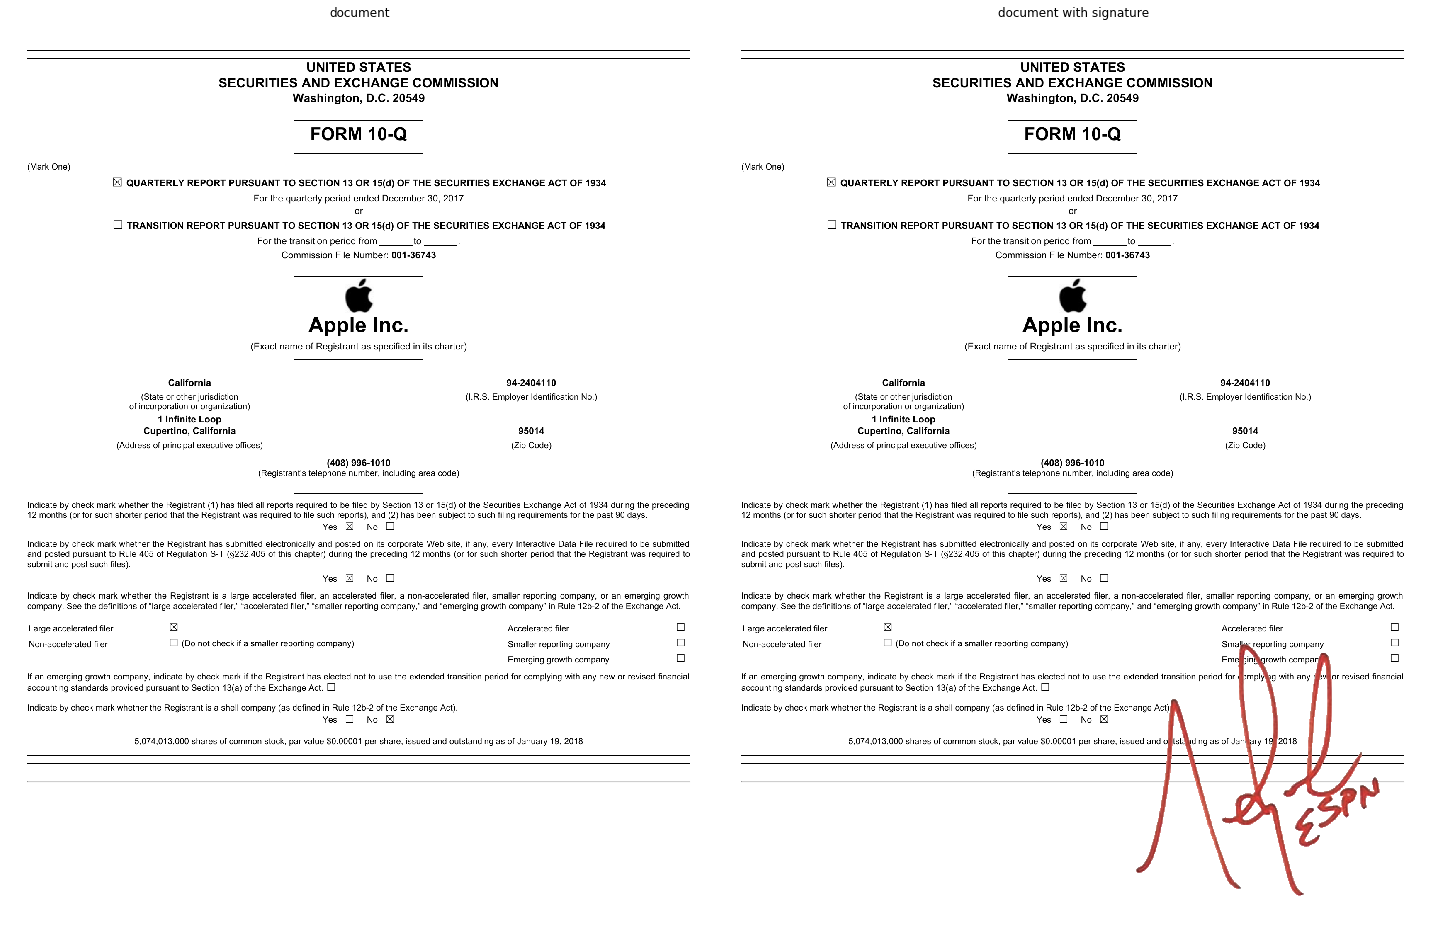

In [11]:
image_with_signature = image.copy()
signature_place = image_with_signature[point[0]: point[0]+ s_h, point[1]:point[1] + s_w]
signature_place = signature_place * (1 - signature_mask) +  signature_image * signature_mask
image_with_signature[point[0]: point[0]+ s_h, point[1]:point[1] + s_w] = signature_place
subplot_images([image, image_with_signature], 1, 2, titles=['document', 'document with signature'])

Рассмотрим классический пример blending 2 фруктов

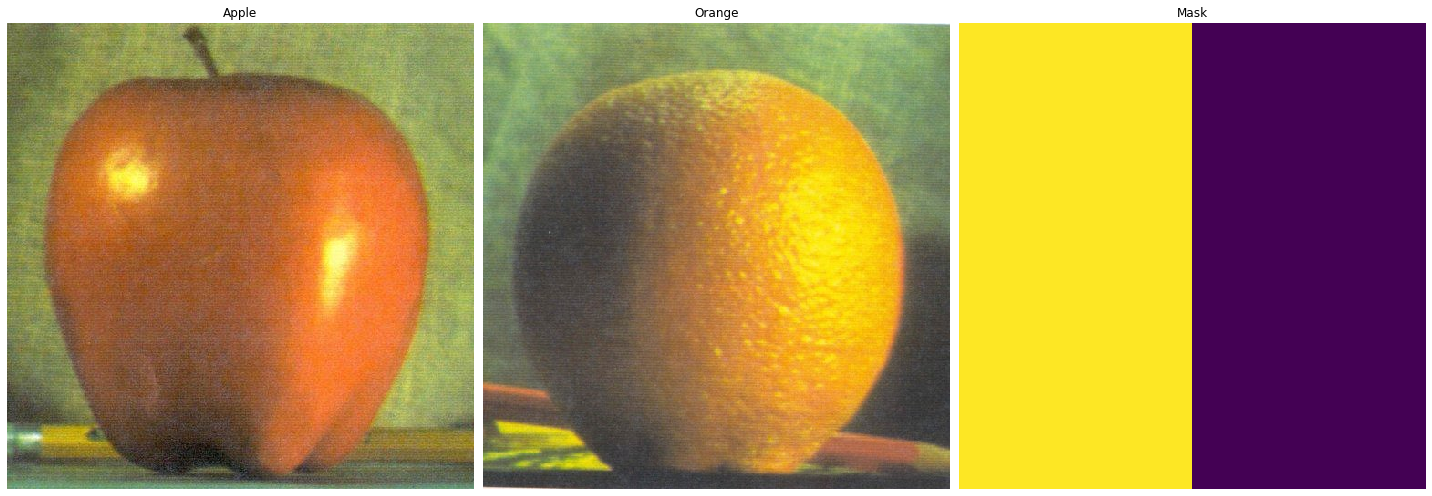

In [12]:
image_apple = cv2.imread('./source_images/apple.png')
image_apple = cv2.cvtColor(image_apple, cv2.COLOR_BGR2RGB)
image_orange = cv2.imread('./source_images/orange.png')
image_orange = cv2.cvtColor(image_orange, cv2.COLOR_BGR2RGB)

image_1 = image_apple.copy()
image_2 = image_orange.copy()
height, weight = image_1.shape[:2]
mask = np.zeros((height, weight)).astype(np.float32)
mask[:, :weight // 2] = 1
subplot_images([image_1, image_2, mask], 1, 3, titles=['Apple', "Orange", "Mask"])

Смешаем два изображения просто по маске, получиться весьма скверно(

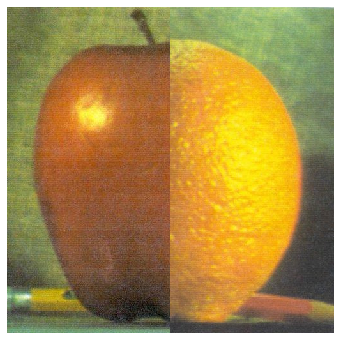

In [13]:
blended_image = image_1 * mask[:, :, None] + image_2 * (1 - mask[:, :, None])
show_image(blended_image.astype(np.uint8), (6, 6))

### Smoothing Blending

Можно несколько сгладить линию соединения изображений с помощью манипуляций с маской. Например можно сгладить маску на границе смешения изображений. В этой случае на маске появятся значения между 0 и 1, и край склеки будет не так заметен. 

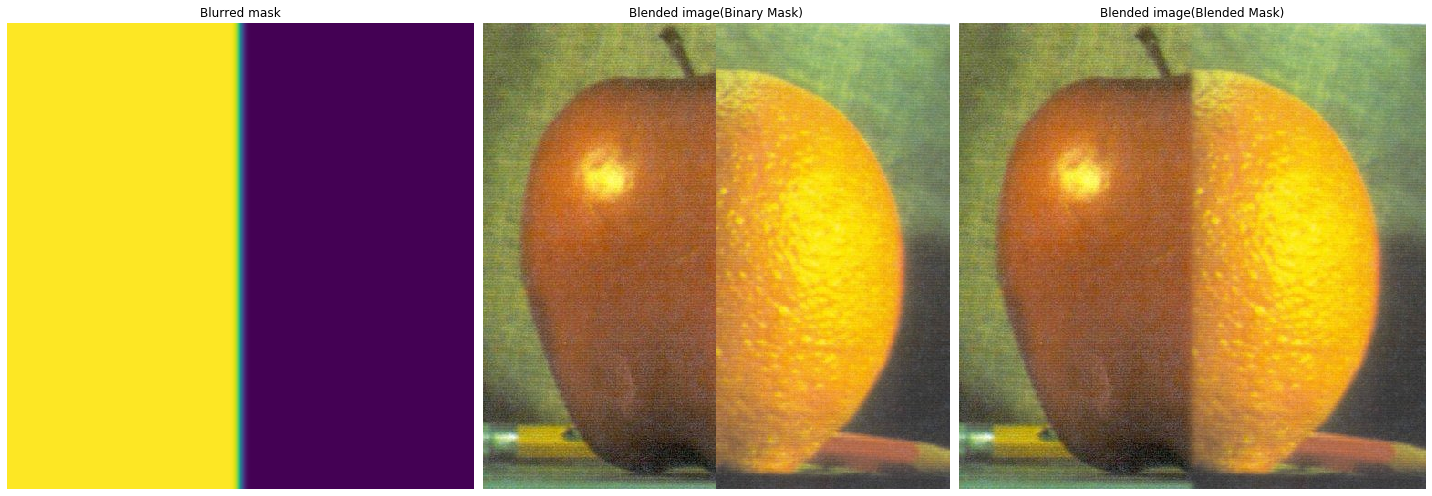

In [14]:
blur = cv2.GaussianBlur(mask,(25,25),0)  # сглаживаем с помощью Gaussian Blurring
blended_image_2 = image_1 * blur[:, :, None] + image_2 * (1 - blur[:, :, None])
subplot_images([blur, blended_image.astype(np.uint8), blended_image_2.astype(np.uint8)], 1, 3, 
              titles=['Blurred mask', 'Blended image(Binary Mask)', 'Blended image(Blended Mask)'])

__Выводы__:

1) Простое смышивание подходит в том случае когда у нас есть качественная маска и мы ходим простой объект наложить на фотографию

2) Можно использовать для того чтобы накладывать водяные знаки, в этом случая маска не бинарная, а между 0 и $\alpha < 1$ , чтобы просвечивал фон

3) Очень дешевая операция

4) Края объектов очень резкие

## Laplacian Blending

Идея в том чтобы сделать переход между двумя изображения плавным, для этого изображения смешиваются на разных частотах по отдельности и потом складываются.

1) Сначала для изображений и для маски создаются пирамиды Гаусса: серия изображений каждое
следующее обработано фильтром гауса(остаются только низкие частоты) и уменьшено в 2 раза

2) Из пирамид гауса для изображений создаются пирамиды Лапласа: на каждом этапе от текущего
слоя отнимается следующий(предварительно увеличенные в 2 раза). Остаются только высокие частоты

<img src="images/Laplacian_Blending_2.png"  width="700px" title="aaa">

3) На каждом слое пирамид Лапласа изображения складываются по маске из пирамиды гауса

4) Все слои пирамиды последовательно от меньшего к большему складываются в одно изображение(слои приводятся к большему размеру на каждом шаге)

Общая схемя показана ниже

<img src="images/Laplacian_Blending_1.png"  width="700px" title="aaa">

In [15]:
num_levels = 5  # количество изображений в пирамиде

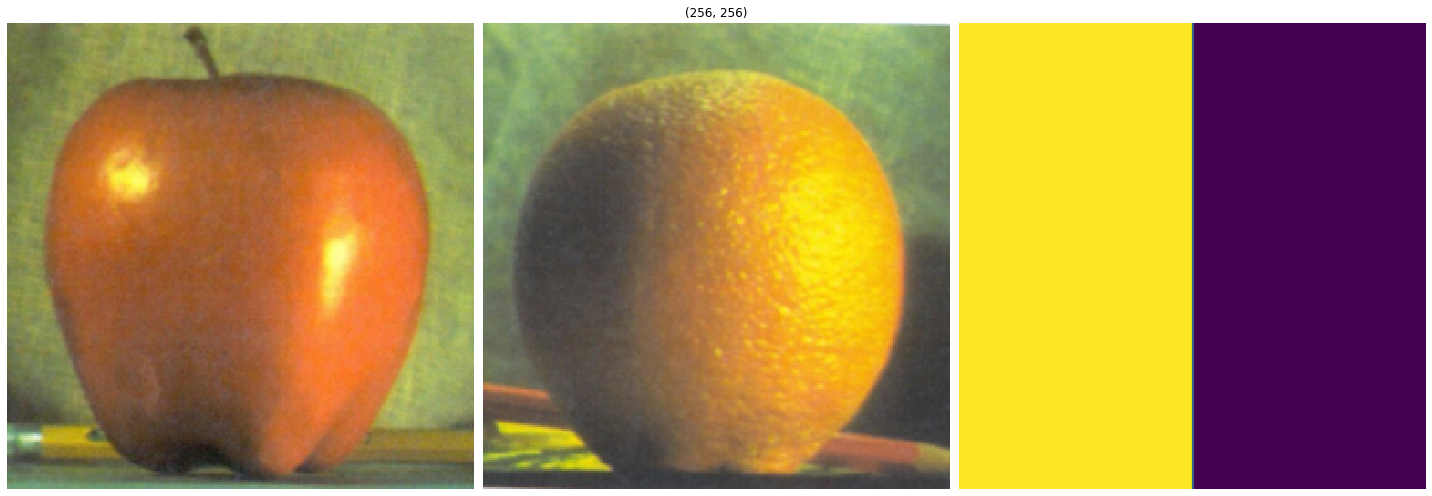

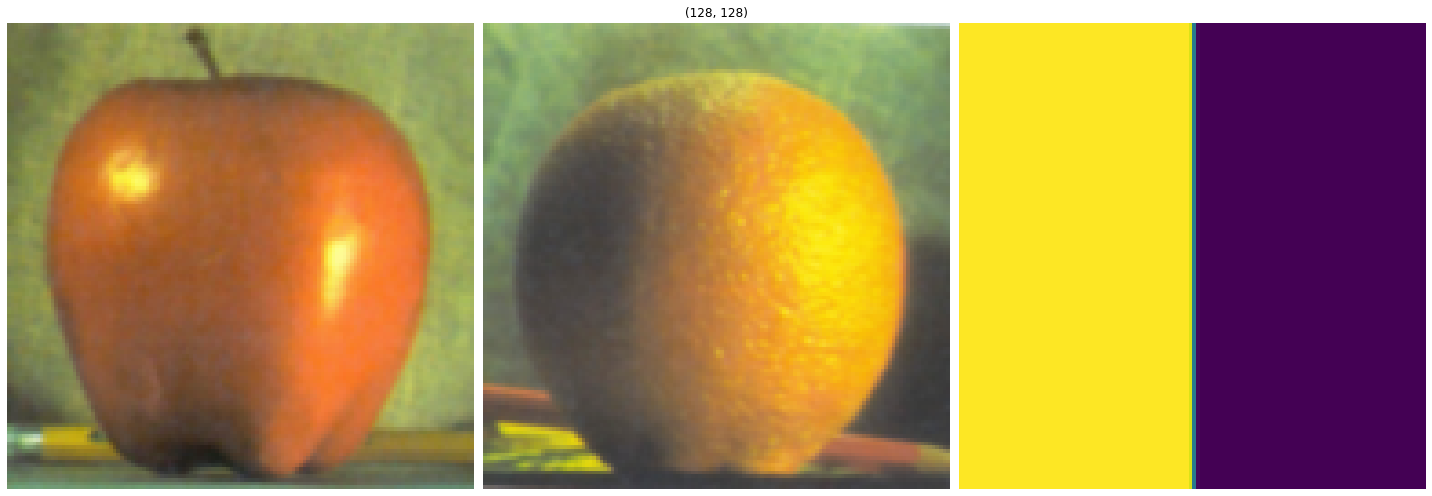

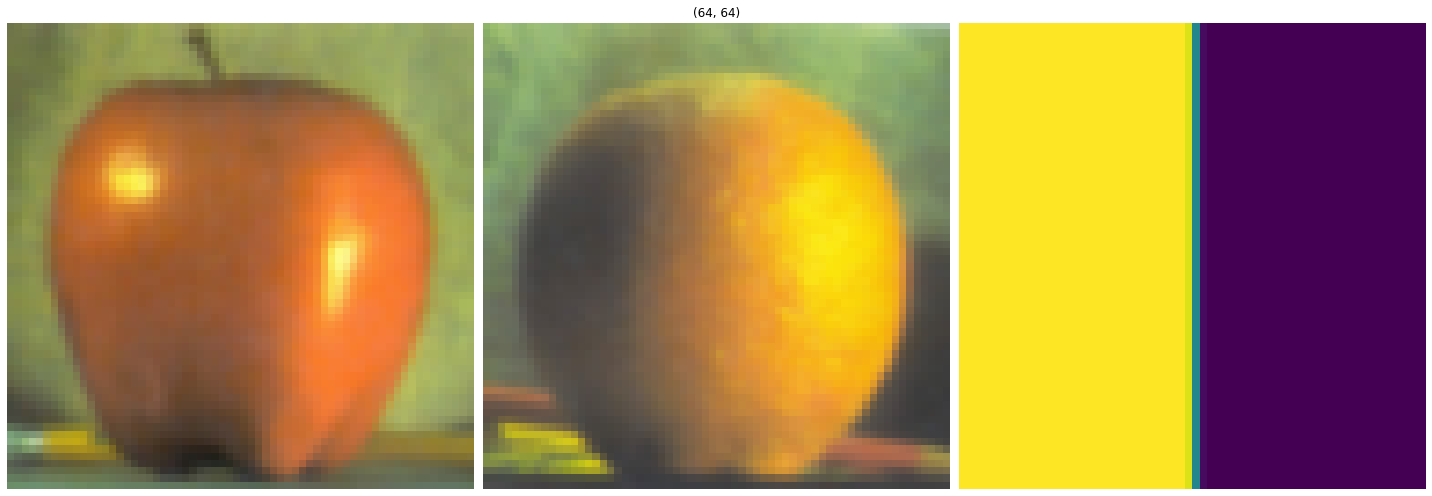

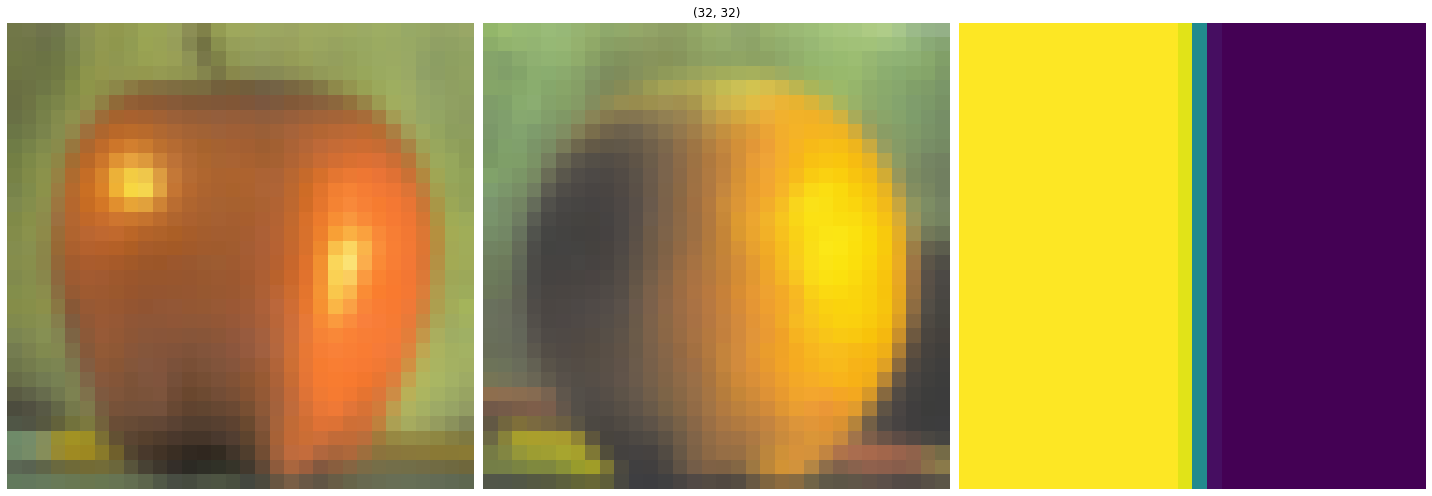

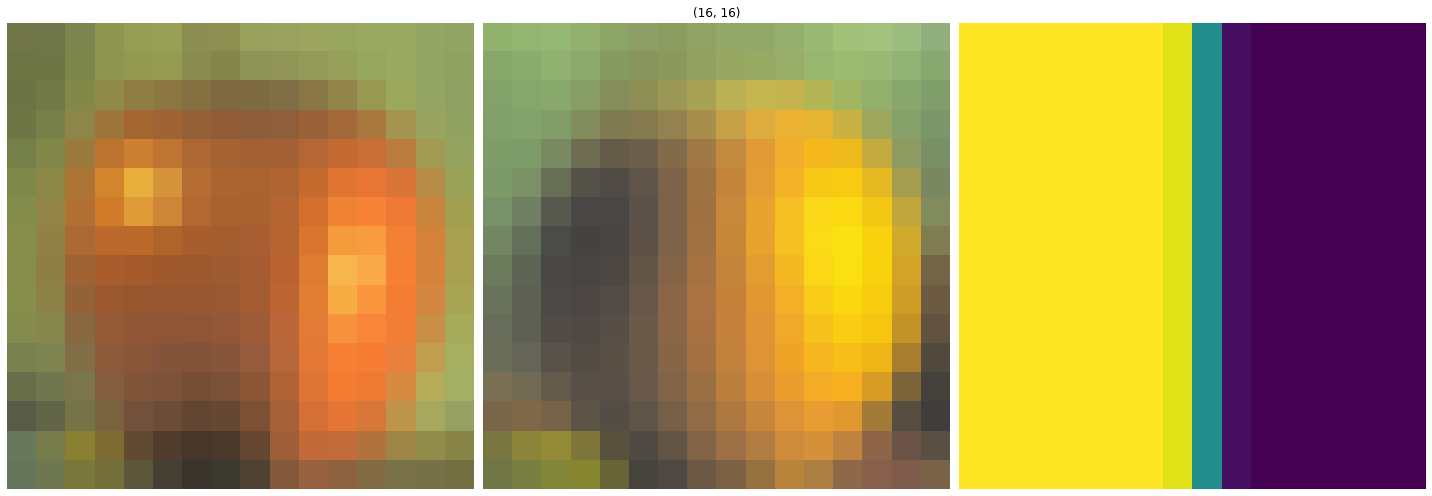

In [16]:
gauss_pyramid_1 = [image_1]
gauss_pyramid_2 = [image_2]
gauss_pyramid_mask = [mask]
for i in range(num_levels):
    image_1 = cv2.pyrDown(image_1)  # сглаживаем и уменьшаем в 2 раза
    image_2 = cv2.pyrDown(image_2)  # сглаживаем и уменьшаем в 2 раза
    mask = cv2.pyrDown(mask)
    subplot_images([image_1, image_2, mask], 1, 3, titles=['', image_1.shape[:2], ''])
    gauss_pyramid_1.append(np.float32(image_1))
    gauss_pyramid_2.append(np.float32(image_2))
    gauss_pyramid_mask.append(np.float32(mask))

(64, 64, 3)


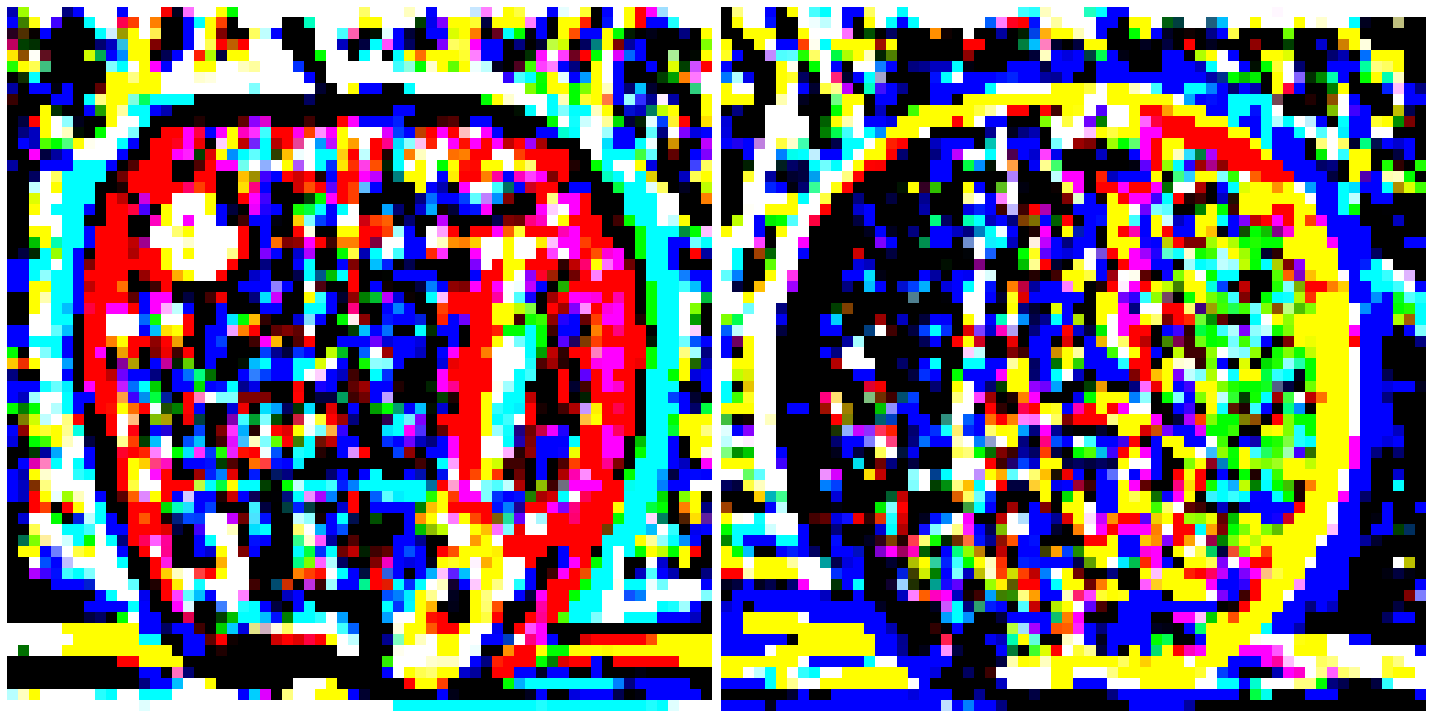

(128, 128, 3)


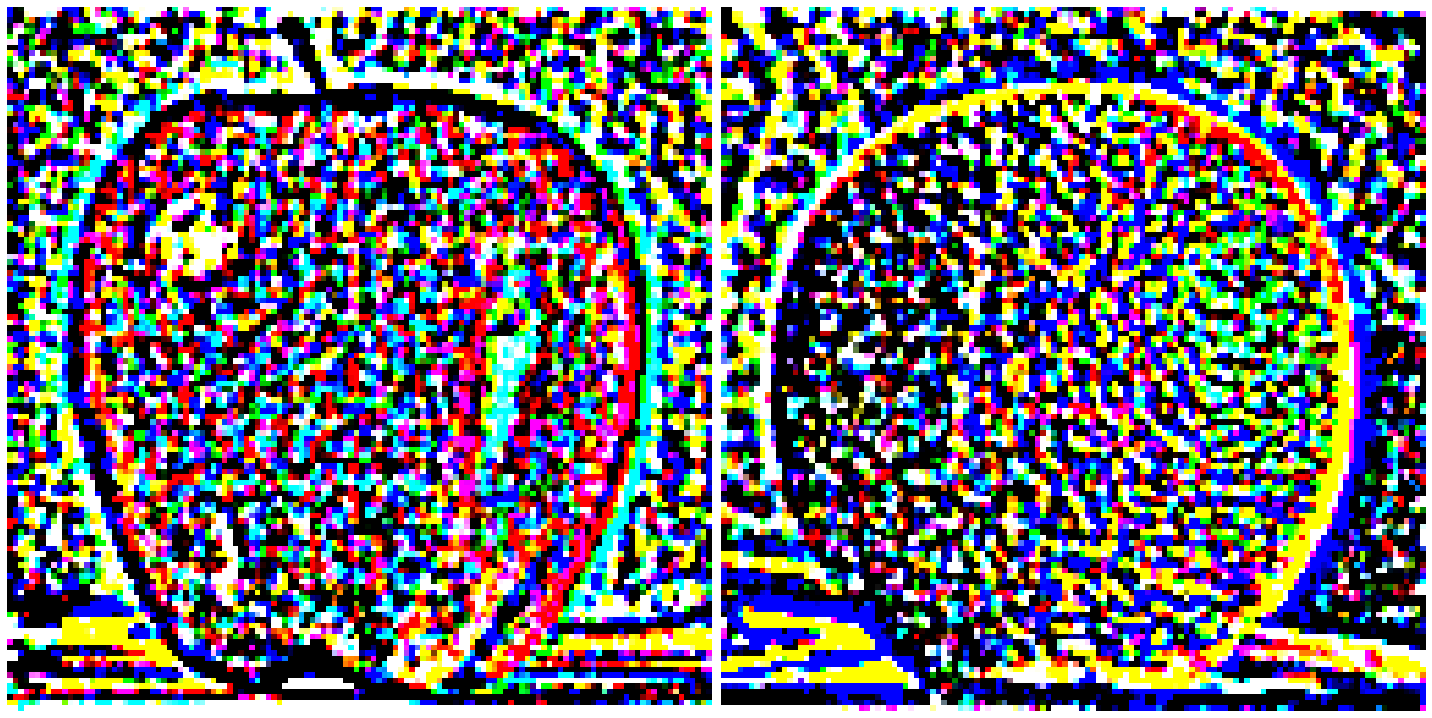

(256, 256, 3)


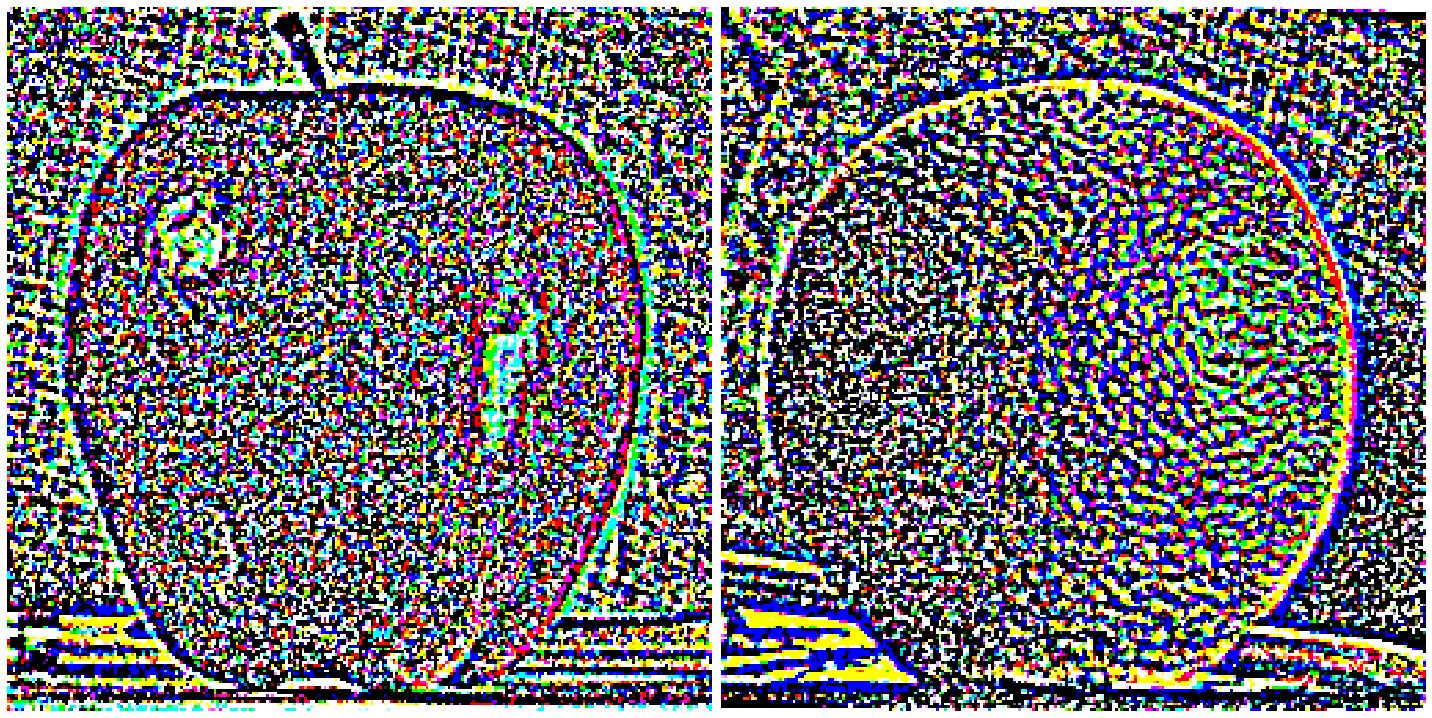

(512, 512, 3)


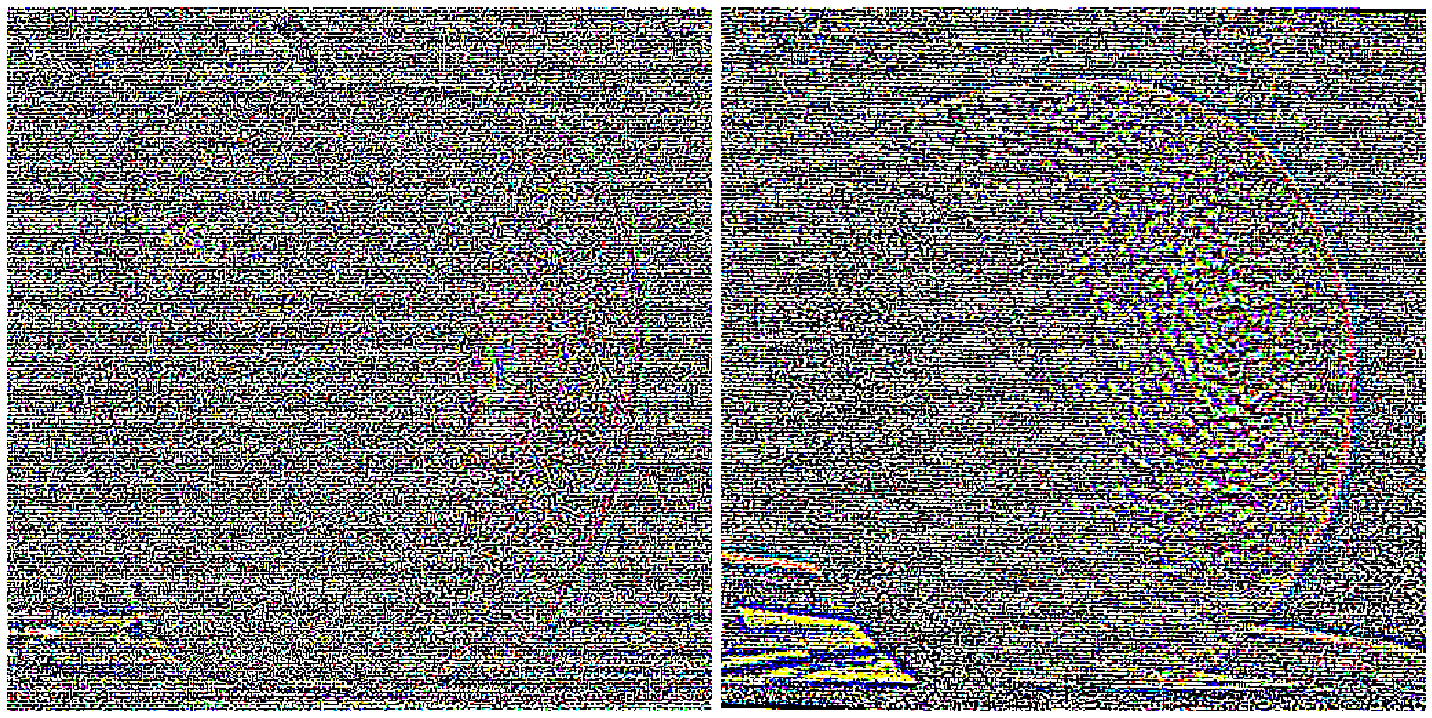

In [17]:
laplacian_pyramid_1 = [gauss_pyramid_1[num_levels - 1]]
laplacian_pyramid_2 = [gauss_pyramid_2[num_levels - 1]]
laplacian_pyramid_mask = [gauss_pyramid_mask[num_levels - 1]]
for i in range(num_levels - 1, 0, -1):
    laplacian_layer_1 = gauss_pyramid_1[i - 1] - cv2.pyrUp(gauss_pyramid_1[i])
    laplacian_layer_2 = gauss_pyramid_2[i - 1] - cv2.pyrUp(gauss_pyramid_2[i])
    print(laplacian_layer_1.shape)
    subplot_images([np.abs(laplacian_layer_1.clip(0, 1)),
                    np.abs(laplacian_layer_2.clip(0, 1))], 1, 2)
    laplacian_pyramid_1.append(laplacian_layer_1)
    laplacian_pyramid_2.append(laplacian_layer_2)
    laplacian_pyramid_mask.append(gauss_pyramid_mask[i - 1])

In [18]:
blended_pyramid = []
for l_1, l_2, g_m in zip(laplacian_pyramid_1, laplacian_pyramid_2, laplacian_pyramid_mask):
    # если изображение цветное, а маска серая, то нужно добавить канал в конец
    if len(l_1.shape) == 3 and len(g_m.shape) == 2:
        g_m = np.expand_dims(g_m, -1)
    laplacian_layer = l_1 * g_m + l_2 * (1.0 - g_m)
    blended_pyramid.append(laplacian_layer)

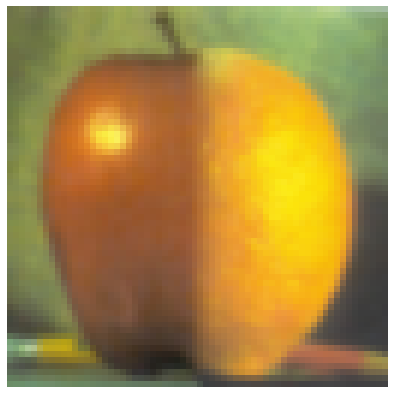

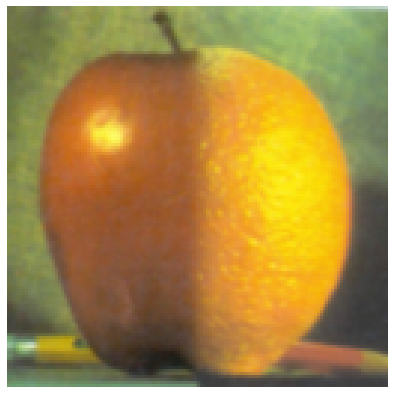

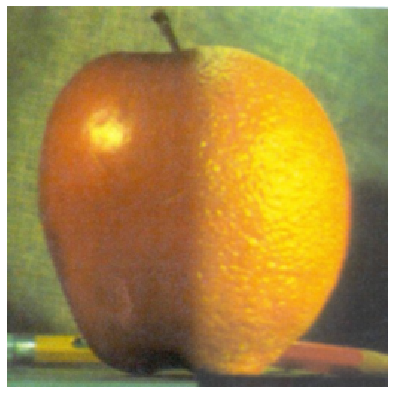

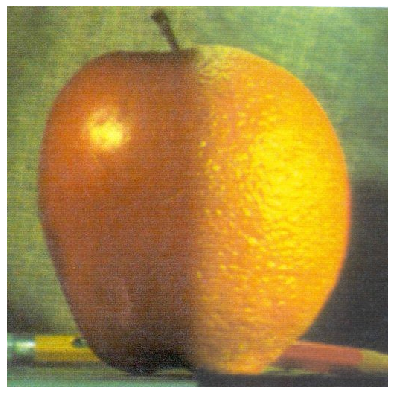

In [19]:
# Реконструируем пирамиду лапласа в итоговое изображение
blended_image = blended_pyramid[0]
for i in range(1, num_levels):
    blended_image = cv2.pyrUp(blended_image)
    blended_image = cv2.add(blended_image, blended_pyramid[i])
    show_image(blended_image.astype(np.uint8), (7, 7))

И сейчас уже можно посмотреть итоговый результат

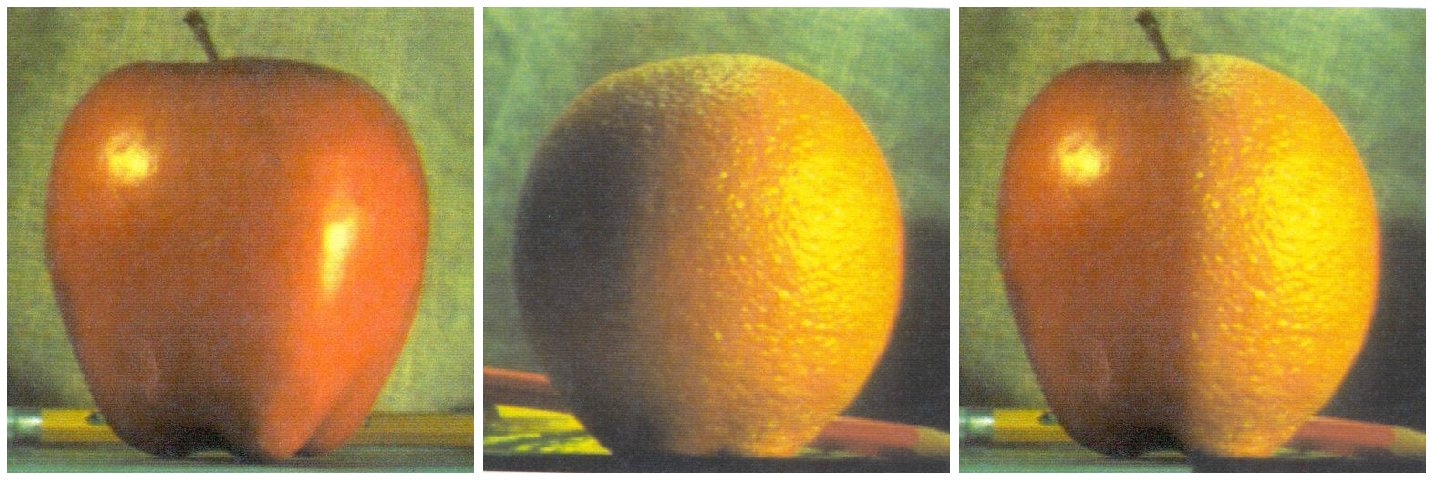

In [20]:
subplot_images([image_apple, image_orange, blended_image.astype(np.uint8)], 1, 3)

__Выводы__:

1) Laplacian Blending сглаживает края изображений, делая смешения на разных уровнях. Сила слаживая и насколько он далеко изображения заходят друг на друга завит от глубины пирамиды

2) Laplacian Blending никак не меняет "внутринность" вставляемого изображения. То есть не переносит стиль и цветовую гамму

3) Относильно дешевый с точки зрения ресурсов

## Poisson Blending

Замечено что человек больше обращает внимание не на сам цвет, а на перепады интенсивности, то есть на градиент изображения. Идея Poisson Blending заключается в том, чтобы от вставляемого изображения сохранить градиенты, то есть контура и структура
объекта, а от исходного изображения сохранить цветовую палитру


<img src="images/poisson_blending_f_1.jpg"  width="500px" title="aaa">

По сути у нас етсь изображение $S$ и мы ходим туда вставить объект $g$. Область на $S$ в которую мы вставляем объект обозначим за $Ω \in S$, край этой области  $∂Ω$. Градиент $g$ обозначим за $v$, при этом нас никто не ограничевает в выборе $v$ это может быть любое векторное поле. Теперь определим $f^*$ - это функция описывающая изображение $S$, таким образом задача blending можно описать так: нужно найти такую функцию $f$, которая бы на краях была идентична $f^*$(краевое условие), а ее градиент был бы максимально близок к $v$, то есть разница между соседними пикселями бы сохранилась:

$$min_f \int \int_Ω |∇f - v|^2 , ~~~~ f|∂Ω = f∗|∂Ω$$

Это можно привести к решению уравнени Пуассона, кроме того гарантируется что решение будет единственно. Можно решить уравнение численнно и найти $f$, подробности http://www.irisa.fr/vista/Papers/2003_siggraph_perez.pdf

__Замечание__: Каждый канал обрабатывается отдельно

__Замечание__: Все вычисления происходят во float и после приводятся в int8, все значения < 0 или > 255 клипаются. При этом это не создает каких либо значимых искажений 

Ниже представленно несколько примеров

<img src="images/poisson_ex_1.jpg"  width="700px" title="aaa">

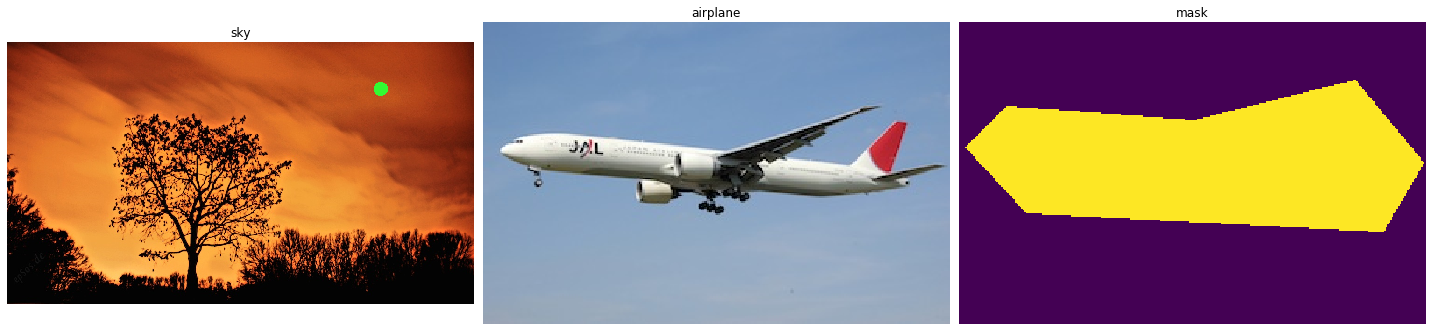

In [21]:
image_airplane = cv2.imread("./source_images/airplane.jpeg")
image_sky = cv2.imread("./source_images/sky.jpg")
image_airplane = cv2.cvtColor(image_airplane, cv2.COLOR_BGR2RGB)
image_sky = cv2.cvtColor(image_sky, cv2.COLOR_BGR2RGB)
mask_airplane = np.zeros(image_airplane.shape[:2], image_airplane.dtype)

# создаем грубую маску самолета
poly = np.array([ [4,80], [30,54], [151,63], [254,37], [298,90], [272,134], [43,122] ], np.int32)
cv2.fillPoly(mask_airplane, [poly], (255, 255, 255))

# Нарисуем точку центра куда будет вставлен самолет
center = (800,100)
image_with_point = draw_points(image_sky, [center], diameter=15, inline=False)

subplot_images([image_with_point, image_airplane, mask_airplane], 1, 3,
               titles=['sky', 'airplane', 'mask'])

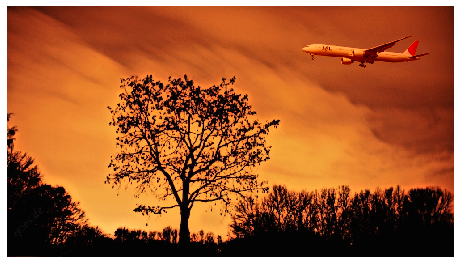

In [22]:
output = cv2.seamlessClone(image_airplane, image_sky, mask_airplane, center, cv2.NORMAL_CLONE)
show_image(output, (8, 8))

### Poisson Blending: MIXED CLONE

В способе который показан выше внутри $Ω$ не остается никаких следов целевого изображения $f^∗$ . Однако бывают ситуации, когда желательно совместить свойства $f^*$ со свойствами $g$. Рассмотрим пример

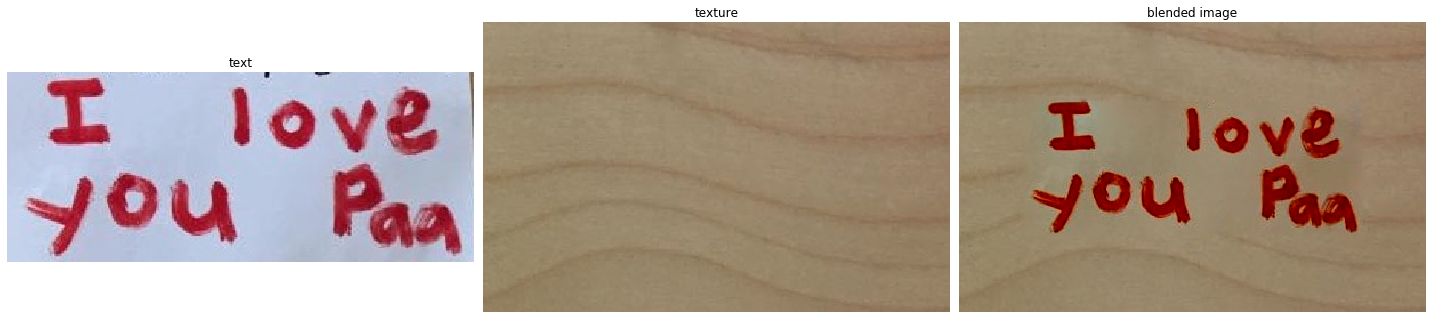

In [24]:
image_texture = cv2.imread("./source_images/wood-texture.jpg")
image_text= cv2.imread("./source_images/iloveyouticket.jpg")
image_texture = cv2.cvtColor(image_texture, cv2.COLOR_BGR2RGB)
image_text = cv2.cvtColor(image_text, cv2.COLOR_BGR2RGB)

# маска будет полностью содержать изображение с текстом
mask = 255 * np.ones(image_text.shape[:2], image_text.dtype)

# текст будет вставлен в центр изображения
width, height = image_texture.shape[:2]
center = (int(height/2), int(width/2))

# 
normal_clone = cv2.seamlessClone(image_text, image_texture, mask, center, cv2.NORMAL_CLONE)
subplot_images([image_text, image_texture, normal_clone], 1, 3,
               titles=['text', 'texture', 'blended image'])

Видно что результат не впечатляет, текстура между буквами сильно сгладилась. Безусловно, результат можно серьезно улучшить если сделать качественную маску. Однако можно сделать по другому, а именно в использовать не просто градиент вставляемго изображения, а __max(исходное изображение, вставляемое изображение)__ . Это сохранит по большей части текстуру исходного изображения и не повредит вставляемому изображению, так как так просто серый фон

<img src="images/poisson_eq_1.jpg"  width="400px" title="aaa">

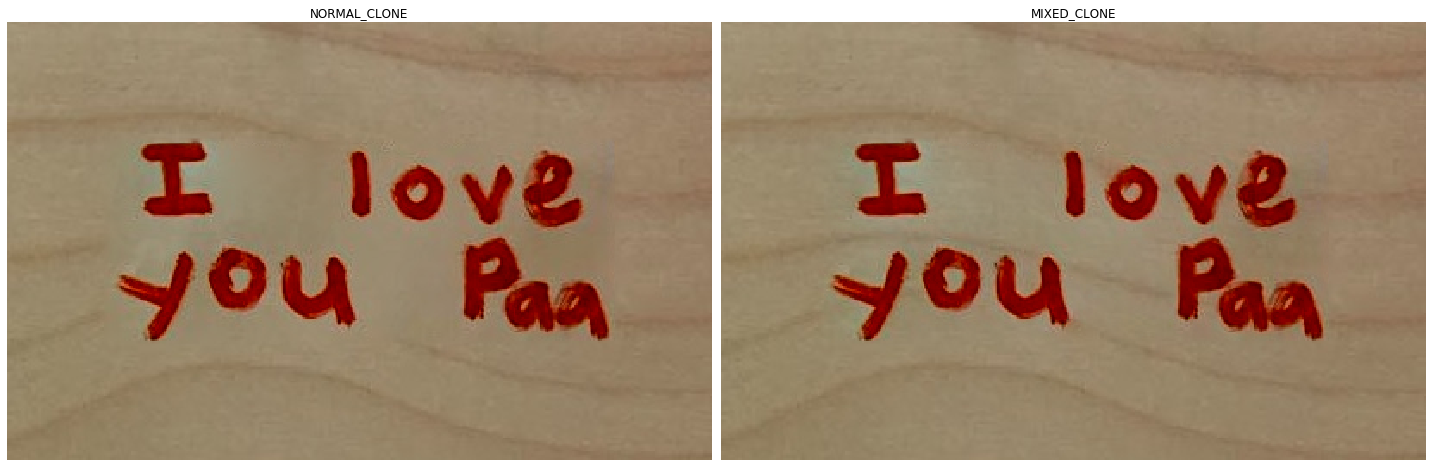

In [25]:
mixed_clone = cv2.seamlessClone(image_text, image_texture, mask, center, cv2.MIXED_CLONE)

subplot_images([normal_clone, mixed_clone], 1, 2, titles=['NORMAL_CLONE', 'MIXED_CLONE'])

При обычном клонировании текстура (градиент) исходного изображения сохраняется в клонированной области. В смешанном клонировании текстура (градиент) клонированной области определяется комбинацией исходного и целевого изображений. Смешанное клонирование не создает гладких областей, поскольку оно выбирает преобладающую текстуру (градиент) между исходным и целевым изображениями. 

__Выводы__:
1) Poisson Blending позволяет вставлять объект в изображение вполне натурально даже в том случае, когда они имеют разную цветовую гамму

2) Во многих случаев даже не требуется качественная маска чтобы результат выглядел "натурально"

3) Сам алгоритм может использоваться и в других целях, например чтобы генерировать текстуру или удалять блики и т.д., см. подробнее http://www.irisa.fr/vista/Papers/2003_siggraph_perez.pdf

4) Тем не менее иногда он очень сильно "размазывает" края и создает артефакты

5) Достаточно медленный и для больших изображений уже может стать узким местом, вычислительная сложность равна O(n^2) по размеру маски.

## DL and Image Blending 

Как правило классичесие методы учитывают только граничные пиксели целевого изображения и, следовательно, не могут адаптироваться к текстуре целевого фонового изображения. Кроме того, цвета целевого изображения часто слишком сильно просачиваются сквозь исходный объект, вызывая значительную потерю содержания исходного объекта.

Можно заметить что задача __Image Blending__ схожа с задачей __Style Transfer__ так как нам нужно чтобы часть изображения была по стиля похожа на ост, поэтому можно использовать подходы из подходов по переносу стиля

### Neural Style Transfer

Чтобы перейти к image blending с использованием deep learning лучше выделить основные моменты в задаче style transfer. 

Цель задачи заключается в переноси стиля с изображения $S$ на изобрадение $I$. Одно из решение этой задачи это  решение оптимизационной задачи $\mathcal{L}(I, S, O) \xrightarrow[O]{} min$, где $O$ — итоговое изображение, $\mathcal{L}(I, S, O)$ — loss фнкция. То есть мы оптимизируем эту loss функцию в пространстве самого изображения.


Пусть $F^l\left[I\right] \in \mathcal{R}^{N_l \times M_l}$ — матрица значений выхода $l$-го слоя сети на изображении $I$. Выход $l$-го слоя сети имеет размерность $N_l \times W_l \times H_l$. Представим его как матрицу $N_l \times M_l$, где $N_l$ — количество фильтров в $l$-ом слое, $M_l$ — количество признаков ($M_l = W_l H_l$). Тогда $F^l_{ij}\left[I\right]$ — $j$-ый признак $i$-го фильтра в $l$-ом слое. Столбец матрицы $F^l\left[I\right]$ размера $N_l$ назовём __вектором активации__

Также нужно ввести еще одно определение: __Матрица Грамма__ $G^l\left[S\right] \in \mathcal{R}^{N_l \times N_l},$ 
$G^l\left[S\right] = F^l\left[S\right]F^l\left[S\right]^T.$


В качестве нейронной сети можно использовать свёрточную нейронную сеть предобученну на ImageNet, например VGG-19.

Теперь можно ввести некоторые loss функции которые используются для стилизации изображений:

__Content loss__

$F^l\left[I\right]$ отражает содержание изображения. Мы хотим чтобы содержание результата было как можно ближе к исходной картинке. 

$$\mathcal{L}_{content}(I, O) = \displaystyle\sum_l \frac{\alpha_l}{2 N_l M_l}\displaystyle\sum_{i, j} \left(F^l_{ij}\left[I\right] - F^l_{ij}\left[O\right]\right)^2,$$

$\alpha_l$ - вес разных слоев 

__Style loss__

$G^l\left[S\right]$ отражает статистику выходов фильтров независимо от их расположения, что, в свою очередь, отражает стиль изображения.

$$\mathcal{L}_{style}(S, O) = \displaystyle\sum_l \frac{\beta_l}{2N_l^2} \displaystyle\sum_{i, j} \left(G^l_{ij}\left[S\right] - G^l_{ij}\left[O\right]\right)^2,$$

$\beta_l$ - вес разных слоев 

__Variation loss__

Функцию потерь, которая удаляет шумы, при этом сохраняя важные детали изображения

$$\mathcal{L}_{tv}(O) = \displaystyle\sum_{i, j} \left(O^l_{i, j} - O^l_{i-1, j}\right)^2 + \left(O^l_{i, j} - O^l_{i, j-1}\right)^2.$$

__Histogram Loss__

Раставляет гистограмму одного изображения быть похожей на гистограмму другого изображения. Нужен для стабильного обучения

## Deep Image Blending

Одной из последних работ по использованию DL в задаче image blending является работа __Deep Image Blending__ https://arxiv.org/abs/1910.11495 

Реализация алгоритма: https://github.com/owenzlz/DeepImageBlending

<img src="images/deep_image_blending_ex_1.jpg"  width="900px" title="aaa">

Для начала авторы вводят еще одну лосс функцию, которая работает аналочно преобразованию Пуасоона, то есть требудлется чтобы градиент вставки был похож на градиент объекта:

$$\mathcal{L}_{grad}(S, I, M, O) = \displaystyle\frac{1}{2HW}\displaystyle\sum_{m=1}^H \displaystyle\sum_{n=1}^W \left[ \mathbf{D}^2 B - \left(\mathbf{D}^2 S + \mathbf{D}^2 I\right) \right]^2_{mn},$$
                        где $H, W$ — высота и ширина изображений. $B = CAP(M, S, O)$ — блендинговое изображение, оптимизируемое относительно $O$.

Данный алгоритм состоит из двух шагов, на вход первому этапу приходит на вход белый шум, а на выходе второго итоговое изображение с вставленным объектом:

1) На первом алгоритм направлен на плавное наложение объекта на фон

2) На втором этапе цель состоит в том чтобы уточнить текстуры и стиля области наложения

Стоит обратить внимание что лосс функции, например content loss высчитывается по маске, только по тем пикселям по которым идет вставка

Алгоритм представлен ниже:

__Замечание__: во второй стадии алгоритма есть опечатка, на самом деле $L_{grad}$ не используется(можно заметить что он даже не определен)

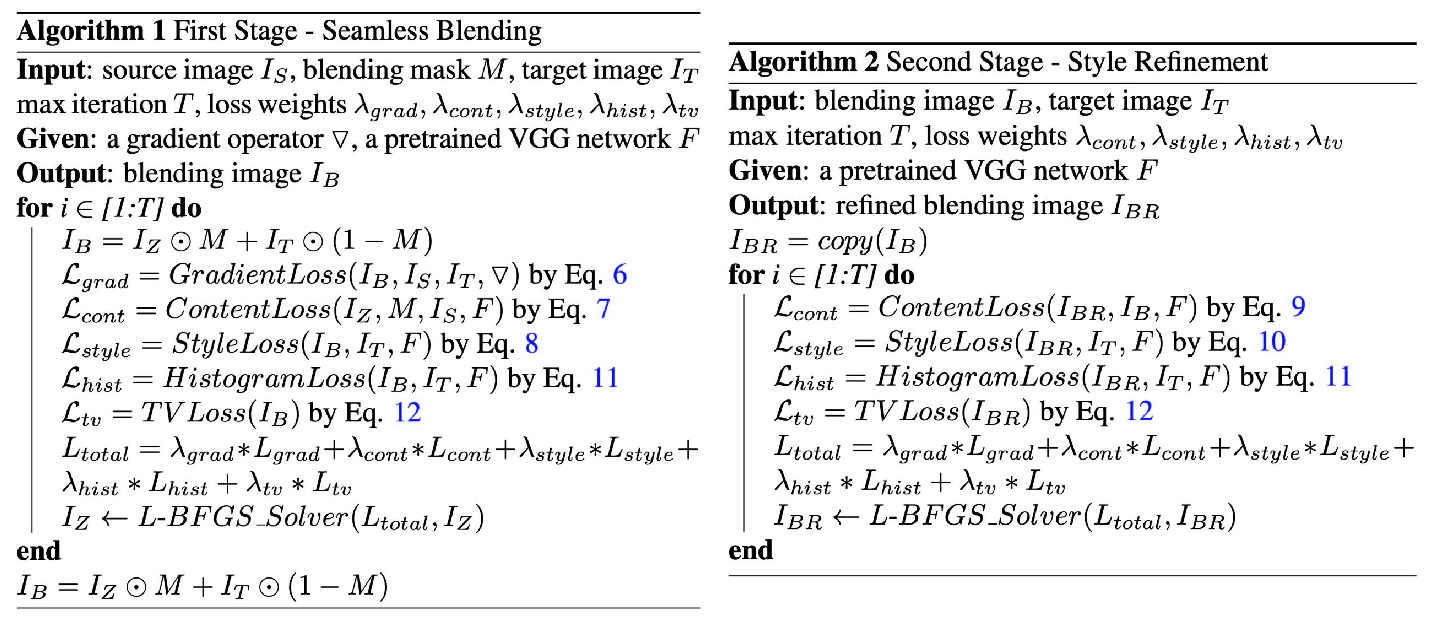

In [26]:
subplot_images(['./images/deep_image_blending_1.jpg', './images/deep_image_blending_2.jpg'], 1, 2)

Стадии реконструкции:

<img src="images/deep_image_blending_3.jpg"  width="900px" title="aaa">

__Выводы__:

1) Не требует обучающих данных, может быть использон из коробки для любых изображений(как реальные изображения так и художественные картины)

2) Можно легко кастомизировать добавляя или удаляя отдельные компонены loss функции

3) Достаточно долгий, так как оптимизируется сразу пиксели изображения

### Дальнейшее чтение: 

1) __GP-GAN: Towards Realistic High-Resolution Image Blending__: о том как использовать GAN для blending изображений с большим разрешением https://arxiv.org/pdf/1703.07195.pdf

2) __Deep Painterly Harmonization__ : Как сделать blending реалистичным для художественных рисунков https://arxiv.org/pdf/1804.03189.pdf